# 🎥 YouTube - Pipeline de Coleta de Comentários

Este notebook implementa a **pipeline de coleta de dados** do projeto *Análise de Sentimentos em Comentários do YouTube*.  
Aqui são coletados os comentários dos vídeos de um canal do YouTube utilizando a API oficial, estruturando a base de dados para análise posterior.

📌 **Etapa:** Pipeline 1 – Coleta de Dados  
📌 **Próxima etapa:** Pipeline 2 – Análise de Sentimentos


## 🔧 1. Importação das bibliotecas

As bibliotecas abaixo permitem a conexão com a API do YouTube, o carregamento de variáveis de ambiente e a manipulação dos dados coletados.


In [ ]:
# Bibliotecas para coleta e organização dos dados
from googleapiclient.discovery import build
from dotenv import load_dotenv
import pandas as pd
import os
import time


## ⚙️ 2. Configurações iniciais

Esta seção carrega as variáveis de ambiente e define os parâmetros principais para a coleta.

- `YOUTUBE_API_KEY` → Chave da API do YouTube.
- `CHANNEL_ID` → Canal que será analisado.
- O notebook coleta, por padrão, os **5 vídeos mais visualizados** do canal.


In [ ]:
import os
from dotenv import load_dotenv

# 🔐 Carregar variáveis do arquivo .env
load_dotenv()

# Leitura das variáveis de ambiente
API_KEY = os.getenv("YOUTUBE_API_KEY")
CHANNEL_ID = os.getenv("CHANNEL_ID")

# Definição fixa de vídeos a coletar (5 mais visualizados)
MAX_VIDEOS = 5

# Validação das variáveis
if not API_KEY or not CHANNEL_ID:
    raise ValueError("⚠️ Verifique se o arquivo .env contém YOUTUBE_API_KEY e CHANNEL_ID corretamente configurados.")

print("✅ Variáveis carregadas com sucesso!")


## 🔌 3. Conexão com a API do YouTube

Nesta etapa é criada a conexão com a API oficial do YouTube, utilizando a biblioteca `googleapiclient`.


In [ ]:
from googleapiclient.discovery import build

try:
    youtube = build("youtube", "v3", developerKey=API_KEY)
    print("✅ Conexão estabelecida com a API do YouTube!")
except Exception as e:
    print("❌ Erro ao conectar à API do YouTube. Verifique sua chave e conexão com a internet.")
    raise e


## 🎯 4. Buscar vídeos do canal

Esta etapa busca os **5 vídeos mais visualizados** do canal informado, com base no parâmetro `viewCount`.  
Os resultados incluem o ID e o título de cada vídeo, que serão usados na coleta de comentários.


In [ ]:
video_data = []

try:
    search_response = youtube.search().list(
        part="id,snippet",
        channelId=CHANNEL_ID,
        maxResults=MAX_VIDEOS,
        order="viewCount",   # 🔄 alterado: busca os vídeos mais visualizados
        type="video"
    ).execute()

    for item in search_response["items"]:
        video_data.append({
            "video_id": item["id"]["videoId"],
            "titulo": item["snippet"]["title"]
        })

    print("✅ Vídeos encontrados:")
    for i, v in enumerate(video_data, 1):
        print(f"{i}. {v['titulo']} (ID: {v['video_id']})")

except Exception as e:
    print("❌ Erro ao buscar vídeos do canal.")
    raise e


## 💬 5. Função para extrair comentários

A função abaixo busca **todos os comentários disponíveis** de um vídeo específico.  
Utiliza paginação (`nextPageToken`) para superar o limite de 100 comentários por requisição.


In [ ]:
def extrair_comentarios(video_id, max_comments=1000):
    """
    Extrai comentários de um vídeo do YouTube, com suporte a paginação.

    Parâmetros:
    - video_id (str): ID do vídeo a ser analisado.
    - max_comments (int): número máximo de comentários a coletar (padrão = 1000).
    """
    comentarios = []
    next_page_token = None

    print(f"\n🔍 Coletando comentários do vídeo: {video_id}")

    while len(comentarios) < max_comments:
        try:
            response = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                textFormat="plainText",
                pageToken=next_page_token
            ).execute()

            for item in response.get("items", []):
                texto = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
                comentarios.append(texto)

            next_page_token = response.get("nextPageToken")
            if not next_page_token:
                break

        except Exception as e:
            print(f"⚠️ Erro ao buscar comentários do vídeo {video_id}: {e}")
            break

    print(f"✅ {len(comentarios)} comentários coletados do vídeo {video_id}")
    return comentarios


## 🧾 Encerramento da Pipeline de Coleta

A coleta de comentários foi concluída com sucesso.  
Os dados foram extraídos via API do YouTube, estruturados em DataFrame e exportados em formato CSV.  

➡️ A próxima etapa (Pipeline 2) será dedicada à **análise de sentimentos**, aplicando modelos de NLP em português sobre os comentários coletados.


## 🧠 6. Carregar o pipeline de análise de sentimentos

Modelo em português disponível na HuggingFace.

In [24]:
from transformers import pipeline

# 🧠 Pipeline de análise de sentimentos em inglês
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)


Device set to use cpu


## 📊 7. Processar comentários de todos os vídeos

In [25]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)


Device set to use cpu


## 🧾 8. Criar DataFrame e salvar resultados

In [29]:
todos_dados = []
for video_id in video_ids:
    comentarios = extrair_comentarios(video_id)
    print(f"Analisando {len(comentarios)} comentários do vídeo {video_id}...")
    for comentario in comentarios:
        try:
            resultado = sentiment_pipeline(comentario[:1000])[0]  # Limitar a 512 caracteres
            todos_dados.append({
                "video_id": video_id,
                "comentario": comentario,
                "label": resultado["label"],
                "score": resultado["score"]
            })
        except Exception as e:
            print(f"Erro ao analisar comentário: {e}")
    time.sleep(1)  # Evitar limites de taxa

Analisando 100 comentários do vídeo 50G0kIty7Cg...
Analisando 100 comentários do vídeo 4l97aNza_Zc...
Analisando 100 comentários do vídeo 3ih2bPKSWsQ...
Analisando 100 comentários do vídeo _AbFXuGDRTs...
Analisando 100 comentários do vídeo TDv56whosPQ...


In [31]:
df = pd.DataFrame(todos_dados)
df.to_csv("comentarios_sentimentos_pt.csv", index=False)
df.head()

,video_id,comentario,label,score
0,50G0kIty7Cg,Who would you call?,1 star,0.291374
1,50G0kIty7Cg,❤️,5 stars,0.308578
2,50G0kIty7Cg,🎉🎉🎉🎉🎉,5 stars,0.308578
3,50G0kIty7Cg,No disponible para LATAM🫤,1 star,0.579419
4,50G0kIty7Cg,❤❤❤❤❤❤❤❤😢😢,5 stars,0.308578


## 📈 9. Visualização dos sentimentos

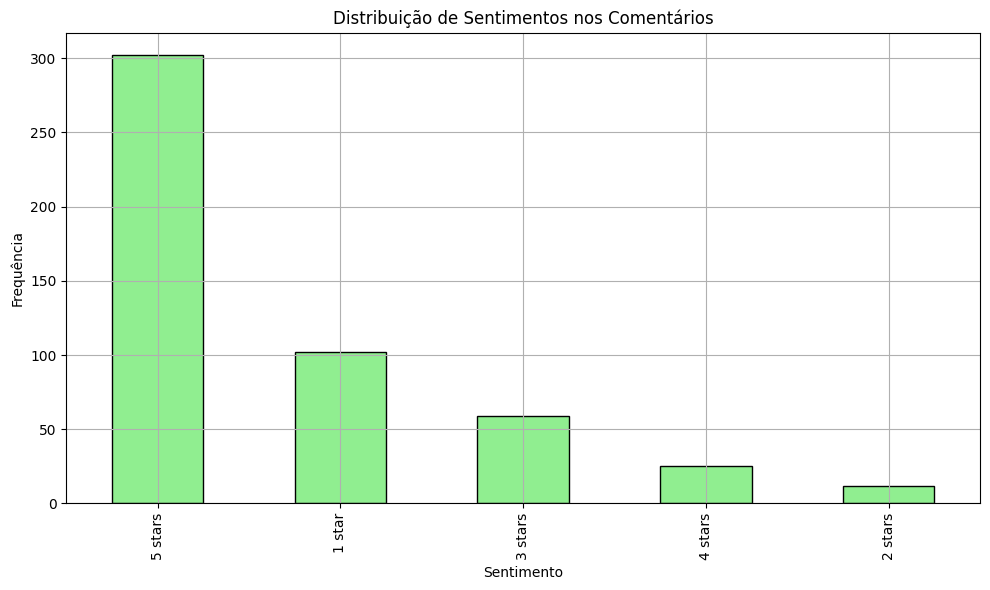

In [32]:
plt.figure(figsize=(10,6))
df["label"].value_counts().plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Distribuição de Sentimentos nos Comentários")
plt.xlabel("Sentimento")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ 10. Conclusão

- O notebook buscou os comentários dos vídeos mais recentes do canal.
- Aplicou análise de sentimentos em português com modelo BERT.
- Exportou os resultados para CSV.
- Gerou gráfico da distribuição de sentimentos.

Possíveis melhorias:
- Processar mais vídeos e comentários.
- Experimentar diferentes modelos de análise de sentimentos.
- Criar visualizações mais ricas (ex.: nuvem de palavras, séries temporais).